# Regression of song year
Another example of real-world data. Here we want to try and predict which years in which songs were released.

The data are discussed in https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd
We have a range of songs from different years, and the features are based on the timbre of the music. The aim is to build a model based on the timbre features to regress to the year of release

Run the cell below to download the data

In [ ]:
!mkdir ./data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip -O ./data/YearPredictionMSD.txt.zip
!unzip ./data/YearPredictionMSD.txt.zip -d ./data/

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Union, Optional, Tuple
from collections import OrderedDict, defaultdict, deque
import os
import math
from pathlib import Path

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.forest import ForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from typing import *
from fastprogress import progress_bar

import torch
from torch import nn, Tensor, optim
from torch.nn.modules.loss import _Loss
from torch.utils.data import DataLoader, Dataset
from torch.nn import BCELoss, MSELoss

# Data Importing
The data is in *Comma Separated Value* (CSV) format. To load it up, we'll use Pandas.

In [3]:
df = pd.read_csv('data/YearPredictionMSD.txt', header=None); print(len(df)); df.head()

515345


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


## Column names
In the dataset as is, the features (columns) are just numbers. We can set them to a more human-readable format

In [4]:
df.columns = ["Target"]+[f'Feat_{i}' for i in range(90)]

In [5]:
df.head()

,Target,Feat_0,Feat_1,Feat_2,Feat_3,Feat_4,Feat_5,Feat_6,Feat_7,Feat_8,...,Feat_80,Feat_81,Feat_82,Feat_83,Feat_84,Feat_85,Feat_86,Feat_87,Feat_88,Feat_89
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


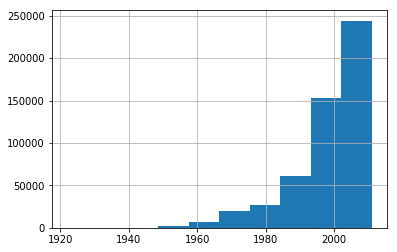

In [6]:
df.Target.hist()

## Validation set
Since we're fitting our model to data, we want to have an unbiased estimate of its performance to help optimise the architecture before we apply the model to the testing data. We can randomly sample a *validation* set from the training data.

For this dataset, a specific split is recommended to avoid the same producer being in both training and validation, which could allow the model to cheat by recognising producers.

In [7]:
df_train,df_val = df[:463715],df[463715:]

In [8]:
len(df_val)

51630

# Feature processing
The data contains both continuous features (real values with numerical comparison) and categorical features (discreet values or string labels with no numerical comparison). Each need to be treated slightly differently.

In [9]:
train_feats = [f for f in df.columns if f != 'Target']

## Continuous preprocessing
The weight initialisation we use is optimal for inputs which are unit-Gaussian. The closest we can get is to shift and scale each feature to have mean zero and standard deviation one. `SK-Learn` has `Pipeline` classes to handle series of transformations to data, and we'll use the `StandardScaler` to transform the data.

In [10]:
input_pipe = Pipeline([('norm_in', StandardScaler(with_mean=True, with_std=True))])

Next we need to fit the transformation to the data. Note the Boolean indexing of the data.

In [11]:
input_pipe.fit(df_train[train_feats].values.astype('float32'))

Pipeline(memory=None,
         steps=[('norm_in',
                 StandardScaler(copy=True, with_mean=True, with_std=True))],
         verbose=False)

And finally apply the transformation to the training, validation, and testing data.

In [12]:
df_train[train_feats] = input_pipe.transform(df_train[train_feats].values.astype('float32'))
df_val[train_feats]   = input_pipe.transform(df_val[train_feats].values.astype('float32'))

/Users/giles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/giles/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/giles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

We can check the transformation by plotting an example feature

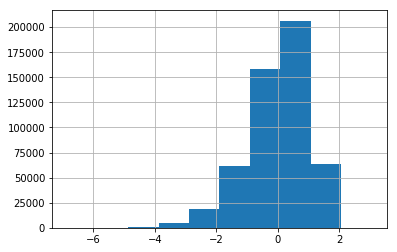

In [13]:
df.Feat_0.hist()

# Model 
Now we need to build a model to fit to the data. Use the previous two example notebooks to help write a function which returns an appropriate model.

In [14]:
class NPDataset(Dataset):
    r'''
    Dataset for dealing with Numpy arrays
    
    Arguments:
        x: input data
        y: Optional target data
        shuffle: whether to shuffle input and target data prior to iteration
        bulk_move: whether to move entire dataset to device at start of iteration (quicker) or move batch by batch (memory efficient)
        bs: batchsize, number of datapoints per minibatch
        device: set to either cuda or cpu, or leave as None for cuda if available else cpu
        drop_last: whether to drop last batch if it is smaller than bs
    '''
    
    def __init__(self, x:np.ndarray, y:Optional[np.ndarray]=None, shuffle:bool=True, bulk_move:bool=True, bs:int=64,
                 device:Optional[torch.device]=None, drop_last:bool=True):
        self.shuffle,self.bulk_move,self.bs,self.drop_last = shuffle,bulk_move,bs,drop_last
        if device is None: self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        else:              self.device = device
        self.x = x.astype('float32')
        if len(self.x.shape) == 1: self.x = self.x[:,None]
        if y is None:
            self.y = y
        else:
            self.y = y.astype('float32')
            if len(self.y.shape) == 1: self.y = self.y[:,None]

    def __len__(self) -> int:
        r'''
        Returns the number of datapoints in the dataset
        '''
        
        return len(self.x)

    def __getitem__(self, idx:int) -> Tuple[Any,Any]:
        r'''
        Returns a single datapoint at the requested index
        '''
        
        if self.y is None: return self.x[idx]
        else:              return self.x[idx], self.y[idx]
        
    def __iter__(self) -> Tuple[Tensor,Tensor]:
        r'''
        Iterates through the entire (shuffled) dataset, yielding minibatches of Tensors on device
        '''
        
        if self.shuffle:
            data = list(zip(self.x, self.y))
            np.random.shuffle(data)
            inputs, targets = zip(*data)
        else:
            inputs, targets = self.x, self.y
            
        if self.bulk_move:  # Moves entire dataset to device
            inputs  = Tensor(inputs).to(self.device)
            if targets is not None: targets = Tensor(targets).to(self.device)
            if self.drop_last:
                for i in range(0, len(inputs)-self.bs+1, self.bs):
                    if targets is not None: yield inputs[i:i+self.bs], targets[i:i+self.bs]
                    else:                   yield inputs[i:i+self.bs]
            else:
                for i in range(0, len(inputs)+1, self.bs):
                    if targets is not None:
                        if i+self.bs < len(inputs): yield inputs[i:i+self.bs], targets[i:i+self.bs]
                        else:                       yield inputs[i:],          targets[i:]
                    else:
                        if i+self.bs < len(inputs): yield inputs[i:i+self.bs]
                        else:                       yield inputs[i:]
        else:
            if self.drop_last:
                for i in range(0, len(inputs)-self.bs+1, self.bs):
                    if targets is not None:
                        yield Tensor(inputs[i:i+self.bs]).to(self.device), Tensor(targets[i:i+self.bs]).to(self.device)
                    else:
                        yield Tensor(inputs[i:i+self.bs]).to(self.device)
            else:
                for i in range(0, len(inputs)+1, self.bs):
                    if targets is not None:
                        if i+self.bs < len(inputs):
                            yield Tensor(inputs[i:i+self.bs]).to(self.device), Tensor(targets[i:i+self.bs]).to(self.device)
                        else:
                            yield Tensor(inputs[i:]).to(self.device),          Tensor(targets[i:]).to(self.device)
                    else:
                        if i+self.bs < len(inputs): yield Tensor(inputs[i:i+self.bs]).to(self.device)
                        else:                       yield Tensor(inputs[i:]).to(self.device)                

In [21]:
class NN(nn.Module):
    r'''
    Full-connected neural network with user-defined depth and width (same width for all dense layers).
    User-configurable output activation function (None for regression, nn.Sigmoid for classification).
    Internal activations are nn.ReLU
    
    Arguments:
        n_int: number of inputs
        depth: number of hidden layers
        width: size of hidden layers
        n_out: width of output layer
        out_act: activation function for output layer (if any)
    '''
    
    def __init__(self, n_in:int, depth:int, width:int, n_out:int, out_act:Optional[Callable[[],nn.Module]],
                 do:Optional[float]=None):
        super().__init__()  # nn.Module.__init__ must always be called to correctly initialise class
        if out_act is None: out_act = lambda: None
        if do is None: do = 0
        self.layers = nn.Sequential(*[self._get_layer(n_in      = n_in      if d   == 0       else width,
                                                      n_out     = width     if d <  depth else n_out,
                                                      act       = nn.ReLU() if d <  depth else out_act(),
                                                      out_layer = d == depth,
                                                      do        = do)
                                      for d in range(depth+1)])
        
    @staticmethod
    def _get_layer(n_in:int, n_out:int, act:Optional[nn.Module], out_layer:bool, do:float) -> nn.Sequential:
        r'''
        Returns a correctly initialised dense layer and optionally an activation layer, as a Sequential model
        '''
        
        layers = []
        
        # Create a single layer and initialise weights and biases
        layers.append(nn.Linear(n_in, n_out))
        if out_layer: nn.init.xavier_normal_(layers[-1].weight)
        else:         nn.init.kaiming_normal_(layers[-1].weight, nonlinearity='relu')
        nn.init.zeros_(layers[-1].bias)
        if act is not None: layers.append(act)
        if not out_layer and do > 0: layers.append(nn.Dropout(do))
        return nn.Sequential(*layers)
    
    def forward(self, x:Tensor) -> Tensor:
        r'''
        Passing input tensor through the neural network and returns the output
        '''
        
        return self.layers(x)

In [22]:
class Model():
    r'''
    Class wrapping a neural network (nn.Module) providing fitting and prediction methods
    Automatically saves the best model during training.
    
    Arguments:
        model: the network to wrap
        device: set to either cuda or cpu, or leave as None for cuda if available else cpu
        bulk_move: whether to move entire dataset to device at start of iteration (quicker) or move batch by batch (memory efficient)
    '''
    
    def __init__(self, model:nn.Module, device:Optional[torch.device]=None, bulk_move:bool=True):
        if device is None: self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        else:              self.device = device
        self.model = self.to_device(model, self.device)
        self.opt = optim.AdamW(self.model.parameters())
        self._n_out = self.get_n_out()
        self.bulk_move = bulk_move
        
    def __repr__(self) -> str:
        return f'''Model:\n{self.model}
        \n\nNumber of trainable parameters: {sum(p.numel() for p in self.model.parameters() if p.requires_grad)}
        \n\nOptimiser:\n{self.opt}
        '''
    
    def get_n_out(self) -> None:
        r'''
        Gets the number of outputs of the network
        '''
        
        l = deque(self.model.parameters(), maxlen=1).pop()
        return len(l.shape)
    
    @staticmethod
    def to_device(x:Union[Tensor,List[Tensor]], device:torch.device) -> Union[Tensor,List[Tensor]]:
        r'''
        Recursively places Tensor(s) onto device

        Arguments:
            x: Tensor(s) to place on device

        Returns:
            Tensor(s) on device
        '''

        if x is None: return x
        if isinstance(x, list): return [Model.to_device(o, device) for o in x]
        return x.to(device)
    
    @staticmethod
    def to_np(x:Tensor) -> np.ndarray:
        r'''
        Converts Tensor x to a Numpy array

        Arguments:
            x: Tensor to convert

        Returns:
            x as a Numpy array
        '''

        return x.cpu().detach().numpy()
    
    def set_lr(self, lr:float) -> None:
        r'''
        Sets learning rate of optimiser
        '''

        self.opt.param_groups[0]['lr'] = lr
        
    def set_wd(self, wd:float) -> None:
        r'''
        Sets weight decay parameter for optimiser
        '''

        self.opt.param_groups[0]['weight_decay'] = wd
    
    def fit(self, x:np.ndarray, y:np.ndarray,
            lr:float, batchsize:int, loss_fn:_Loss, n_epochs:int, wd:Optional[float]=None,
            x_val:Optional[np.ndarray]=None, y_val:Optional[np.ndarray]=None) -> Tuple[List[float],List[float]]:
        r'''
        Fits model to data (optionally using validation data) for a set number of epochs.
        Automatically tracks best performance and loads best model at end of training
        
        Arguments:
            x: training inputs
            y: training targets
            lr: learning rate
            batchsize: size of minibatches
            loss_fn: Loss function to use
            n_epochs: number of epochs to train
            wd: amount of weight decay penalisation
            x_val: optional validation inputs
            y_val: optional validation targets
        
        Returns:
            Tuple of train and validation losses
        '''
        
        def save_best(loss:float, best_loss:float) -> float:
            if loss < best_loss:
                best_loss = loss
                print(f'New best loss of {best_loss:.3E}')
                self.save("best.h5")
            return best_loss
        
        self.model.train()  # Put model into train mode (local gradients saved during forward pass, dropout active, etc.)
        trn_losses,val_losses = [],[]
        trn_dl = NPDataset(x,y, bs=batchsize, shuffle=True, bulk_move=self.bulk_move)
        if wd is None: wd = 0
        self.set_wd(wd)
        self.set_lr(lr)
        best_loss = math.inf
        
        epoch_pb = progress_bar(range(n_epochs), display=True, leave=True)
        for e in epoch_pb:
            losses = []  # Holder for losses during epoch
            for x, y in trn_dl:  # Loop over batches
                x,y = self.to_device(x, self.device),self.to_device(y, self.device)  # Put data on device
                y_pred = self.model(x)  # Run forward pass of network and get prediction
                loss = loss_fn(y_pred, y)  # Compute loss of prediction
                losses.append(loss.data.item())  # Get value of loss
                self.opt.zero_grad()  # Reset recorded gradients
                loss.backward()  # Propagate loss gradient backwards through network
                self.opt.step()  # Perform one update step to network parameters
            
            trn_losses.append(np.mean(losses))
            if x_val is not None:
                val_losses.append(self.evaluate(x_val,y_val, batchsize=batchsize, loss_fn=loss_fn))
                epoch_pb.comment = f'Epoch {e+1}, best loss: {np.min(val_losses):.4E}'
                best_loss = save_best(val_losses[-1], best_loss)
            else:
                epoch_pb.comment = f'Epoch {e+1}, best loss: {np.min(trn_losses):.4E}'
                best_loss = save_best(trn_losses[-1], best_loss)
        
        print(f'Fit complete loading best model with loss of {best_loss:.3E}')
        self.load("best.h5")
        self.plot_train_history([trn_losses,val_losses])
        return trn_losses,val_losses
    
    def save(self, filename:Union[Path,str]) -> None:
        torch.save({'model':self.model.state_dict(), 'opt':self.opt.state_dict()}, str(filename))
        
    def load(self, filename:Union[Path,str]) -> None:
        state = torch.load(str(filename), map_location=self.device.type)
        self.model.load_state_dict(state['model'])
        self.opt.load_state_dict(state['opt'])
    
    @staticmethod
    def plot_train_history(history:Tuple[List[float],List[float]]) -> None:
        r'''
        Plots loss evolution as a function of training epoch
        '''
        plt.figure(figsize=(16,9))
        plt.plot(history[0], label='Training')
        if len(history[1]) > 0:
            plt.plot(history[1], label='Validation')
            plt.vlines(np.argmin(history[1]), ymin=np.min(history[0]), ymax=np.max(history[0]), linestyles='--')
        else:
            plt.vlines(np.argmin(history[0]), ymin=np.min(history[0]), ymax=np.max(history[0]), linestyles='--')
        plt.legend(loc='upper right', fontsize=16)
        if history[0][0]/np.min(history[0]) > 50: plt.yscale('log', nonposy='clip')
        plt.grid(True, which="both")
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.xlabel("Epoch", fontsize=24)
        plt.ylabel("Loss", fontsize=24)
        plt.show()
    
    def evaluate(self, x:np.ndarray, y:np.ndarray, batchsize:int, loss_fn:_Loss) -> float:
        r'''
        Computes mean loss on network predicitons for data
        '''
        
        self.model.eval()  # Put model into eval mode no grads saved, dropout turned off, etc.
        loss = []
        dl = NPDataset(x,y, bs=batchsize, shuffle=True, bulk_move=self.bulk_move, device=self.device)
        for x, y in dl:  # Loop over batches
            x,y = self.to_device(x, self.device),self.to_device(y, self.device)  # Put data on device
            y_pred = self.model(x)  # Run forward pass of network and get prediction
            loss.append(loss_fn(y_pred, y).data.item())  # Get value of loss
        return np.mean(loss)
    
    def predict(self, x:np.ndarray, batchsize:Optional[int]=None) -> np.ndarray:
        r'''
        Computes preditions for network on data
        '''
        
        self.model.eval()  # Put model into eval mode no grads saved, dropout turned off, etc.
        if batchsize is None:  # Compute all predictions at once
            x = x.astype('float32')
            if len(x.shape) == 1: x = x[:,None]
            preds = self.model(self.to_device(Tensor(x), self.device))
        else:
            dl = NPDataset(x, bs=batchsize, shuffle=False, bulk_move=self.bulk_move, drop_last=False, device=self.device)
            preds = torch.zeros((len(x),self._n_out), device=self.device)
            for i, x in enumerate(progress_bar(dl, leave=True)):  # Loop over batches
                x = self.to_device(x, self.device)  # Put inputs on device
                ps = self.model(x)  # Run forward pass of network and get prediction
                if len(ps) == batchsize: preds[i*batchsize:(1+i)*batchsize] = ps
                else:                    preds[i*batchsize:]                = ps  # Last batch
        return self.to_np(preds)

In [26]:
model = Model(NN(n_in=len(train_feats), depth=4, width=100, n_out=1, out_act=None, do=0.1)); model

Model:
NN(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=90, out_features=100, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (4): Sequential(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)
        

Number of trainable parameters: 39501
        

Optimiser:
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)
        

In [24]:
x, y = df_train[train_feats].values, df_train.Target.values
x_val, y_val = df_val[train_feats].values, df_val.Target.values

New best loss of 4.268E+02
New best loss of 1.045E+02
New best loss of 9.909E+01
New best loss of 9.846E+01
New best loss of 8.308E+01
New best loss of 8.305E+01
New best loss of 8.249E+01
Fit complete loading best model with loss of 8.249E+01


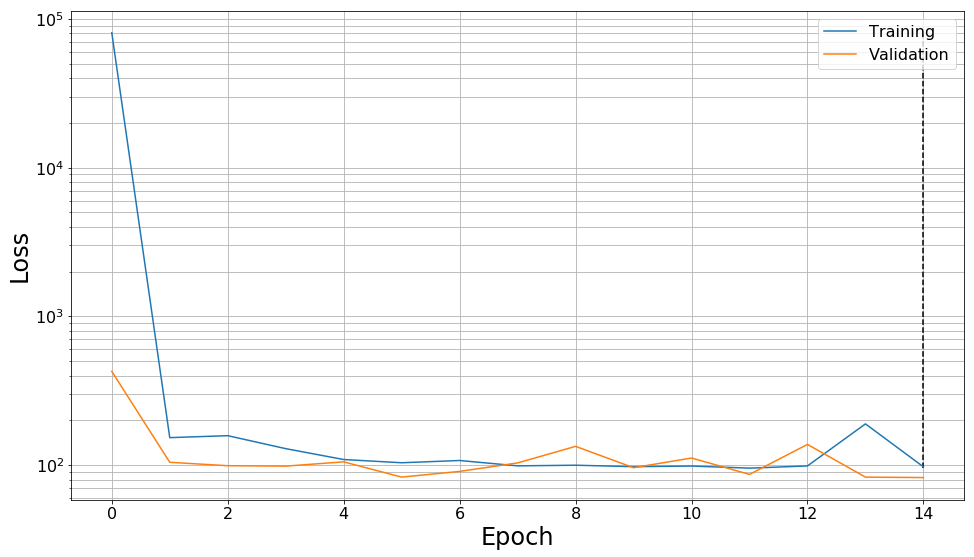

In [27]:
hist = model.fit(x=x, y=y, x_val=x_val, y_val=y_val, batchsize=128, n_epochs=15, lr=2e-3, wd=1e-7, loss_fn=MSELoss())

# Tricks

Unlike classification, where the target values are between 0 and 1, in regression the targets can be any real number.
Since we are initialising the neural networks to expect inputs in the region [-1,1] and to produce unit-Gaussian outputs, the final layer has to do a lot of work to shift the unit-Gaussian input to the range and scale of our target data. This also means that during the first few epochs, we can get some extremely large gradients flowing through the network, since the initial predictions could be several orders of magnitude out.

## Bias initialisation
One solution is to set the bias on the output layer to an appropriate value, such as the mean value of the training targets. As we saw during the `SGD_from_scratch` notebook, the first few updates focus on setting the bias, so we can speed up convergence by setting it beforehand. The network will now initially output a unit-Gaussian centred aroung the bias value, so it doesn't help with the range of the targets.

In [40]:
model = Model(NN(n_in=len(train_feats), depth=4, width=100, n_out=1, out_act=None, do=0.1)); model

Model:
NN(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=90, out_features=100, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (4): Sequential(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)
        

Number of trainable parameters: 39501
        

Optimiser:
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)
        

In [43]:
model.model.layers[-1][-1].bias

Parameter containing:
tensor([0.], requires_grad=True)

In [46]:
nn.init.constant_(model.model.layers[-1][-1].bias, val=y.mean())

Parameter containing:
tensor([1998.3861], requires_grad=True)

In [47]:
model.model.layers[-1][-1].bias

Parameter containing:
tensor([1998.3861], requires_grad=True)

New best loss of 7.939E+01
New best loss of 7.821E+01
New best loss of 7.800E+01
Fit complete loading best model with loss of 7.800E+01


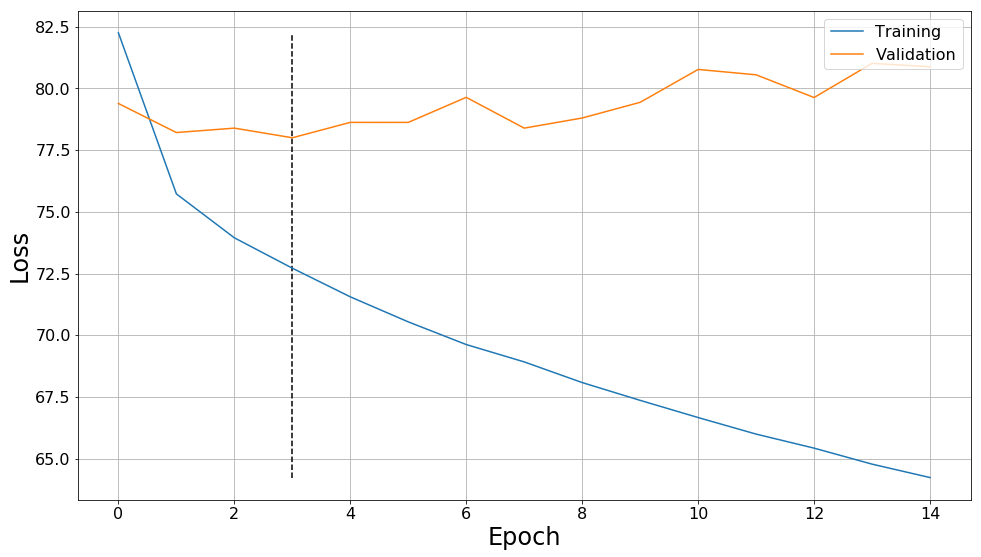

In [48]:
hist = model.fit(x=x, y=y, x_val=x_val, y_val=y_val, batchsize=128, n_epochs=15, lr=2e-3, wd=1e-7, loss_fn=MSELoss())

So, convergence took 4 epochs instead of 15.

## Preprocess targets
Another approach is to preprocess the targets to have mean zero and standard deviation 1, like we did with the inputs. The network can now be trained on the preocessed targets, and then for actual prediction, the network outputs can be inverse-transformed to the actual target range. This solves both the range and scale problems, but adds some extra steps.

In [49]:
model = Model(NN(n_in=len(train_feats), depth=4, width=100, n_out=1, out_act=None, do=0.1)); model

Model:
NN(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=90, out_features=100, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (4): Sequential(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)
        

Number of trainable parameters: 39501
        

Optimiser:
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)
        

In [56]:
output_pipe = Pipeline([('norm_out', StandardScaler(with_mean=True, with_std=True))])
output_pipe.fit(y[:,None])
y_proc     = output_pipe.transform(y[:,None])
y_val_proc = output_pipe.transform(y_val[:,None])

New best loss of 6.636E-01
New best loss of 6.525E-01
New best loss of 6.505E-01
New best loss of 6.441E-01
Fit complete loading best model with loss of 6.441E-01


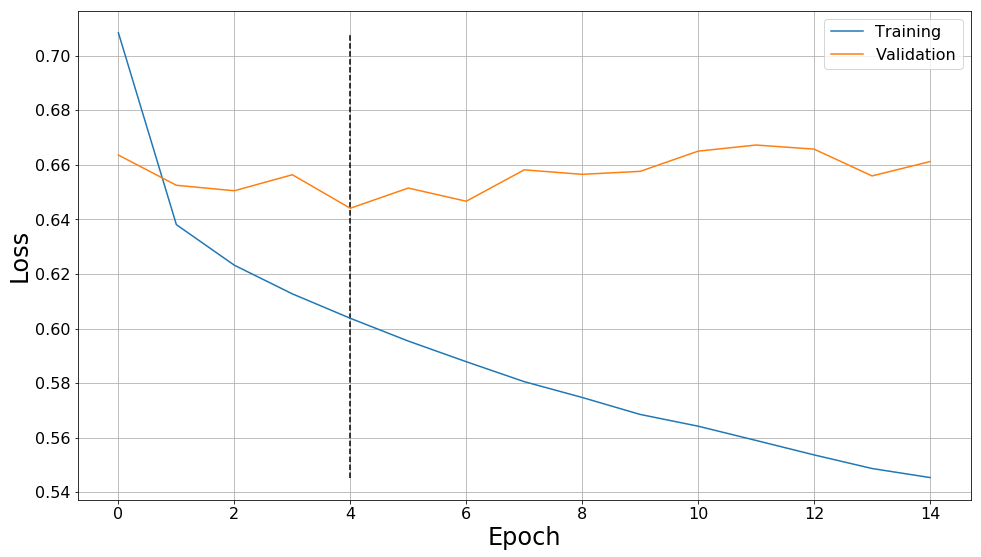

In [60]:
hist = model.fit(x=x, y=y_proc, x_val=x_val, y_val=y_val_proc, batchsize=128, n_epochs=15, lr=2e-3, wd=1e-7,
                 loss_fn=MSELoss())

In [61]:
from sklearn.metrics import mean_squared_error

In [62]:
mean_squared_error(y_val, output_pipe.inverse_transform(model.predict(x_val)))

77.0781047350439

Note that instead of preprocessing the targets, the inverse transform could be incorporated into the forward method of the network:

In [78]:
class InverseProcNN(NN):
    def __init__(self, n_in:int, depth:int, width:int, n_out:int, out_act:Optional[Callable[[],nn.Module]],
                 do:Optional[float]=None, mean:Optional[float]=None, std:Optional[float]=None):
        super().__init__(n_in=n_in, depth=depth, width=width, n_out=n_out, out_act=out_act, do=do)
        self.mean,self.std = mean,std
    
    def forward(self, x:Tensor) -> Tensor:
        x = super().forward(x)
        if self.mean is not None:
            x = x*self.std
            x = x+self.mean
        return x

In [82]:
model = Model(InverseProcNN(n_in=len(train_feats), depth=2, width=100, n_out=1, out_act=None, do=0.1,
                           mean=y.mean(), std=y.std())); model

Model:
InverseProcNN(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=90, out_features=100, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)
        

Number of trainable parameters: 19301
        

Optimiser:
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)
        

New best loss of 7.903E+01
New best loss of 7.768E+01
New best loss of 7.758E+01
Fit complete loading best model with loss of 7.758E+01


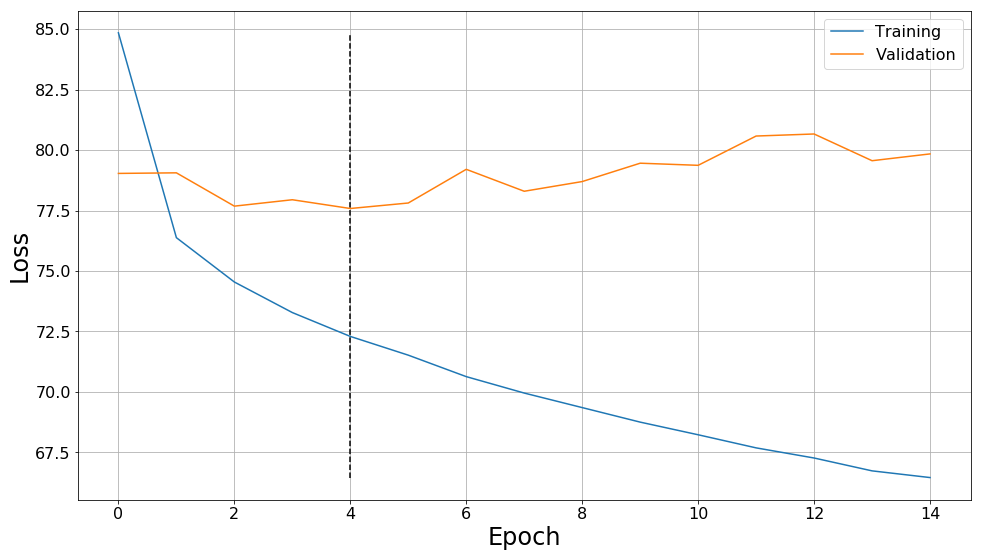

In [83]:
hist = model.fit(x=x, y=y, x_val=x_val, y_val=y_val, batchsize=128, n_epochs=15, lr=2e-3, wd=1e-7, loss_fn=MSELoss())

## Sigmoid output
Another approach is to use a sigmoid output activation function to constrain the output to be in the range [0,1], and then to rescale this range to match the target. This method prevents large outputs during the initial stages of training from spoiling convergence, and doesn't assume that the targets are Gaussian-distributed.

In [28]:
class RegressionNN(NN):
    def __init__(self, n_in:int, depth:int, width:int, n_out:int, out_act:Optional[Callable[[],nn.Module]],
                 do:Optional[float]=None, y_range: Optional[Tuple[float,float]]=None):
        super().__init__(n_in=n_in, depth=depth, width=width, n_out=n_out, out_act=out_act, do=do)
        self.y_range = y_range
        if self.y_range is not None: self.y_diff = self.y_range[1]-self.y_range[0]
    
    def forward(self, x:Tensor) -> Tensor:
        x = super().forward(x)
        if self.y_range is not None: x = (self.y_diff*x)+self.y_range[0]
        return x

We need to know the range of our targets, however, since the validation/test data may contain values outside this range, we want to allow some flexibility, especially since the sigmoid only asymptotically converges to 0 or 1.

In [84]:
y_range = (y.min()-3, y.max()+3); y_range

(1919, 2014)

In [85]:
model = Model(RegressionNN(n_in=len(train_feats), depth=2, width=100, n_out=1, out_act=nn.Sigmoid, do=0.1,
                           y_range=y_range)); model

Model:
RegressionNN(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=90, out_features=100, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
)
        

Number of trainable parameters: 19301
        

Optimiser:
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)
        

New best loss of 8.008E+01
New best loss of 7.919E+01
New best loss of 7.778E+01
Fit complete loading best model with loss of 7.778E+01


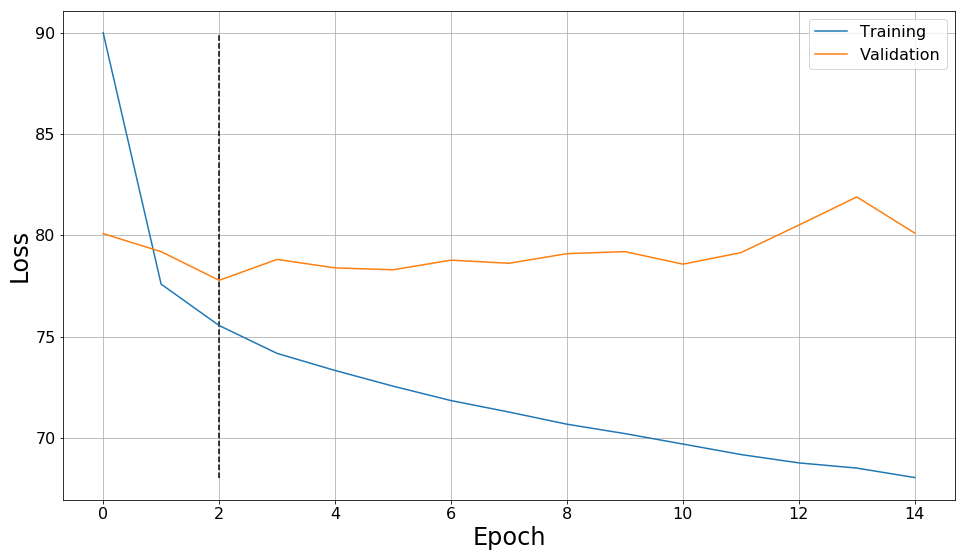

In [86]:
hist = model.fit(x=x, y=y, x_val=x_val, y_val=y_val, batchsize=128, n_epochs=15, lr=2e-3, wd=1e-7, loss_fn=MSELoss())

# Baseline
With any new dataset, it's always useful to try a simpler method as well (if applicable), to get a baseline score for performance to help check that the more advanced method it working correctly and worth using.
Random Forests provide decent performance and are relatively robust to hyper-parameters and data, so can be useful for getting a baseline.

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=256, max_features='sqrt')

In [37]:
rf.fit(x,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=256, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [39]:
mean_squared_error(y_val, rf.predict(x_val))

92.30682986506342

So, the neural networks are to quite well.